# A Medical History of British India as Data
Created in July and August 2020 for the National Library of Scotland's Data Foundry by Lucy Havens, Digital Library Research Intern

### About the *A Medical History of British India* Dataset
The dataset consists of 468 official publications from British India, mainly from 1850-1950, that report on public health, disease mapping, vaccination efforts, veterinary experiments, and other medical topics.  The publications are a subset of a larger collection of 40,000 volumes that report on the administration of British India.  The Wellcome Trust funded the digitization of the medical history volumes in this dataset.
* Data format: digitised text
* Data creation process: Optical Character Recognition (OCR) and manual cleaning
* Data source: https://data.nls.uk/data/digitised-collections/a-medical-history-of-british-india/

### 0. Preparation
Import libraries to use for cleaning, summarizing and exploring the data:

In [1]:
# To prevent SSL certificate failure
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Libraries for data loading
import pandas as pd
import numpy as np
import string
import re

# Libraries for visualization
import altair as alt
import matplotlib.pyplot as plt

# Libraries for text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.draw.dispersion import dispersion_plot as displt

[nltk_data] Downloading package punkt to /Users/lucy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


The nls-text-indiaPapers folder (downloadable as *Just the text* data from the website at the top of this notebook) contains TXT files of digitized text, with numerical names, as well as a CSV inventory file and a TXT ReadMe file.  Load only the TXT files of digitized text and **tokenize** the text (which splits a string into separate words and punctuation):

In [2]:
corpus_folder = 'data/nls-text-indiaPapers/'
wordlists = PlaintextCorpusReader(corpus_folder, '\d.*', encoding='latin1')
corpus_tokens = wordlists.words()
print(corpus_tokens[:10])

['No', '.', '1111', '(', 'Sanitary', '),', 'dated', 'Ootacamund', ',', 'the']


*Note: If you'd like to see how to specify a single TXT file to load as data, check out the Jupyter Notebook for the Britain and UK Handbooks!*

It's hard to get a sense of how accurately the text has been digitized from this list of 10 tokens, so let's look at one of these words in context.  To see phrases in which "India" is used, we can use the concordance() method:

In [3]:
t = Text(corpus_tokens)
t.concordance('India', lines=20)  # by default NLTK's concordance method displays 25 lines

Displaying 20 of 16495 matches:
ffg . Secretary to the Government of India . Resolution of Government of India 
 India . Resolution of Government of India No . 1 - 137 , dated 5th March 1875 
rch 1875 . Letter from Government of India No . 486 , dated 5th September 1876 
ember 1876 . Letter to Government of India No . 1063 , dated 26th ditto . REFER
ffg . Secretary to the Government of India , Home Department . REFERRING to par
 to paragraph 8 of the Government of India ' s Resolu - tion No . 1 - 136 , dat
inion expressed by the Government of India that any measures of segragation and
filth with which all the villages in India are surrounded is quite sufficient t
the disease in Rajputana and Central India are in the hands of the Presidency S
ffg . Secretary to the Government of India , Home Dept . IN continuation of my 
 the Resolution of the Government of India , Home Department ( Medical ), No 1 
d by the orders of the Government of India dated 5th March 1876 . Report on lep
e to the

The *A Medical History of British India* (MHBI) dataset has been digitized and then manually corrected for errors in the digitization process, so we can be pretty confident in the quality of the text for this dataset.

Let's find out just how much text and just how many files we're working with:

In [4]:
def corpusStatistics(plaintext_corpus_read_lists):
    total_chars = 0
    total_words = 0
    total_sents = 0
    total_files = 0
    for fileid in plaintext_corpus_read_lists.fileids():
        total_chars += len(plaintext_corpus_read_lists.raw(fileid))
        total_words += len(plaintext_corpus_read_lists.words(fileid))
        total_sents += len(plaintext_corpus_read_lists.sents(fileid))
        total_files += 1
    print("Total...")
    print("  Characters in MHBI Data:", total_chars)
    print("  Words in MHBI Data:", total_words)
    print("  Sentences in MHBI Data:", total_sents)
    print("  Files in MHBI Data:", total_files)

corpusStatistics(wordlists)

Total...
  Characters in MHBI Data: 122297870
  Words in MHBI Data: 28333479
  Sentences in MHBI Data: 1671768
  Files in MHBI Data: 468


The `fileids` are the names of the files in the data's source folder:

In [5]:
fileids = list(wordlists.fileids())
fileids[0:3]

['74457530.txt', '74457800.txt', '74458285.txt']

We can use the inventory CSV file from the source folder to match the titles of the papers to the corresponding `fileid`:

In [6]:
df = pd.read_csv('data/nls-text-indiaPapers/indiaPapers-inventory.csv', header=None, names=['fileid', 'title'])
df.head()  # prints the first 5 rows (df.tail() prints the last 5 rows)

,fileid,title
0,74457530.txt,Distribution and causation of leprosy in Briti...
1,74457800.txt,"Report of an outbreak of cholera in Suhutwar, ..."
2,74458285.txt,Report of an investigation into the causes of ...
3,74458388.txt,Account of plague administration in the Bombay...
4,74458575.txt,Inquiry into the circumstances attending an ou...


We can also create a list of the titles from the dataframe column:

In [7]:
titles = list(df['title'])
titles[0:3]   # Display the first three titles (from index 0 up to but not including index 3)

['Distribution and causation of leprosy in British India 1875 - IP/HA.2',
 'Report of an outbreak of cholera in Suhutwar, Bulliah sub-division - IP/30/PI.2',
 'Report of an investigation into the causes of the diseases known in Assam as Kála-Azár and Beri-Beri - IP/3/MB.5']

Variables that store the characters, words, and sentences in our dataset will be useful for future analysis.  Let's create those now:

In [8]:
def getCharsWordsSents(plaintext_corpus_read_lists, fileids):
    all_chars = []
    chars_by_file = dict.fromkeys(fileids)
    all_words = []
    words_by_file = dict.fromkeys(fileids)
    all_words_lower = []
    words_lower_by_file = dict.fromkeys(fileids)
    all_sents = []
    sents_by_file = dict.fromkeys(fileids)
    for fileid in plaintext_corpus_read_lists.fileids():
        
        file_chars = plaintext_corpus_read_lists.raw(fileid)
        all_chars += [str(char).lower() for char in file_chars]
        chars_by_file[fileid] = all_chars
        
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words_lower += [str(word).lower() for word in file_words if word.isalpha()]
        words_lower_by_file[fileid] = all_words_lower
        all_words += [str(word) for word in file_words  if word.isalpha()]
        words_by_file[fileid] = all_words
        
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))  #plaintext_corpus_read_lists.sents(fileid)
        all_sents += [str(sent) for sent in file_sents]
        sents_by_file[fileid] = all_sents
        
    return all_chars, chars_by_file, all_words, words_by_file, all_words_lower, words_lower_by_file, all_sents, sents_by_file
        
mhbi_chars, mhbi_file_chars, mhbi_words, mhbi_file_words, mhbi_words_lower, mhbi_file_lower_words, mhbi_sents, mhbi_file_sents = getCharsWordsSents(wordlists, fileids)

To make sure the function worked as expected, we can run some quick tests with the output lists and dictionaries:

In [11]:
print(mhbi_file_chars[fileids[100]][:10])
print(mhbi_file_words[fileids[355]][30:40])
print(mhbi_file_sents[fileids[-1]][-20:-10])
assert(len(mhbi_file_chars) == len(fileids))  # nothing prints if passes, error prints if doesn't pass

['n', 'o', '.', ' ', '1', '1', '1', '1', ' ', '(']
['Government', 'of', 'India', 'No', 'dated', 'March', 'Letter', 'from', 'Government', 'of']
['By Assistant Director of Public Health or District Health Officers.', 'By Inspectors of Vaccination or other Inspecting Officers.', 'By Assistant Director of Public Health or District Health Officers.', 'By Inspectors of Vaccination or other Inspecting Officers.', 'Primary.', 'Re- vaccina- tions.', 'Primary.', 'Re- vaccina- tions.', 'Primary.', 'Re- vaccina- tions.']


In [12]:
print(mhbi_chars[:100])
print(mhbi_words[6100:6120])
print(mhbi_sents[-5:])
assert(len(mhbi_words_lower) == len(mhbi_words))  # nothing prints if passes, error prints if doesn't pass

['n', 'o', '.', ' ', '1', '1', '1', '1', ' ', '(', 's', 'a', 'n', 'i', 't', 'a', 'r', 'y', ')', ',', ' ', 'd', 'a', 't', 'e', 'd', ' ', 'o', 'o', 't', 'a', 'c', 'a', 'm', 'u', 'n', 'd', ',', ' ', 't', 'h', 'e', ' ', '6', 't', 'h', ' ', 'o', 'c', 't', 'o', 'b', 'e', 'r', ' ', '1', '8', '7', '6', '.', ' ', 'f', 'r', 'o', 'm', '-', 't', 'h', 'e', ' ', 'h', 'o', 'n', 'o', 'u', 'r', 'a', 'b', 'l', 'e', ' ', 'w', '.', ' ', 'h', 'u', 'd', 'l', 'e', 's', 't', 'o', 'n', ',', ' ', 'c', 'h', 'i', 'e', 'f']
['can', 'be', 'de', 'fined', 'as', 'the', 'special', 'home', 'of', 'leprosy', 'And', 'the', 'same', 'remark', 'holds', 'good', 'of', 'all', 'districts', 'It']
['APPENDIX A.APPENDICES.', '43 APPENDIX B.44 APPENDICES.', 'APPENDIX B.APPENDICES.', '45 APPENDIX C.(46) APPENDIX D. GRAPHS SHOWING THE VACCINATIONS PERFORMED AND THE DEATHS FORM SMALL-POX IN BURMA (EXCLUDING BACKWARD TRACTS) SINCE THE YEAR 1922-23 [NLS note: a graphic appears here - see image of page] G.B.C.P.O.APPENDIX E. Diagram showin

Looking good!

### 1. Data Cleaning and Standardization

Since the OCR has already been manually cleaned, we'll focus this section on identifying the roots of words and the parts of speech in sentences, rather than looking for mistakes in the OCR.

First let's create lists of strings from the NLTK tokens that we can use in future analysis:

In [13]:
str_tokens = [str(word) for word in corpus_tokens]
assert(type(str_tokens[0]) == str)  # quick test to make sure the output is as expected
print(str_tokens[0:10])

# Lowercase text
lower_str_tokens = [t.lower() for t in str_tokens]
print(lower_str_tokens[-10:])

# Exclude stop words (i.e. the, a, is) - note that the input text must be lowercased!
eng_stopwords = set(stopwords.words('english'))
no_stopwords = [t for t in lower_str_tokens if not t in eng_stopwords]
print(no_stopwords[500:510])
assert(len(no_stopwords) < len(str_tokens))

# Alphabetic tokens only (exclude digits and punctuation)
alpha_tokens = [t for t in str_tokens if t.isalpha()]
alpha_tokens_lower = [t for t in lower_str_tokens if t.isalpha()]
print(alpha_tokens[1000:1010])
assert(len(alpha_tokens_lower) == len(alpha_tokens))

['No', '.', '1111', '(', 'Sanitary', '),', 'dated', 'Ootacamund', ',', 'the']
['g', '.', 'b', '.', 'c', '.', 'p', '.', 'o', '.']
[',', '424', '705', '491', '214', '8', '11', '5', 'surat', '607']
['the', 'twenty', 'cases', 'mentioned', 'above', 'seventeen', 'are', 'said', 'to', 'have']


Then, we'll **stem** the tokens, or reduce the tokens to their root.  NLTK has two types of stemmers that use different algorithms to determine what the root of a word is.  Here's a sample of what they look like (note that this code can take several minutes to run, so you may wish to choose only one stemmer):

In [14]:
# Stem the text (reduce words to their root, whether or not the root is a word itself
porter = nltk.PorterStemmer()
porter_stemmed = [porter.stem(t) for t in alpha_tokens_lower]
print(porter_stemmed[500:600])
print()
lancaster = nltk.LancasterStemmer()
lancaster_stemmed = [lancaster.stem(t) for t in alpha_tokens_lower]
print(lancaster_stemmed[500:600])

['the', 'govern', 'of', 'india', 'that', 'ani', 'measur', 'of', 'segrag', 'and', 'medic', 'treatment', 'of', 'leper', 'throughout', 'the', 'countri', 'would', 'be', 'impractic', 'as', 'a', 'state', 'measur', 'but', 'i', 'do', 'hold', 'that', 'the', 'improv', 'of', 'the', 'hygien', 'condit', 'under', 'which', 'the', 'mass', 'of', 'the', 'peopl', 'live', 'is', 'the', 'onli', 'sure', 'method', 'of', 'stamp', 'out', 'leprosi', 'or', 'ani', 'similar', 'diseas', 'the', 'filth', 'with', 'which', 'all', 'the', 'villag', 'in', 'india', 'are', 'surround', 'is', 'quit', 'suffici', 'to', 'prevent', 'ani', 'hope', 'of', 'success', 'in', 'combat', 'the', 'diseas', 'which', 'it', 'is', 'not', 'difficult', 'to', 'forese', 'will', 'prevail', 'until', 'such', 'an', 'objection', 'state', 'of', 'matter', 'is', 'alter', 'with', 'these']

['the', 'govern', 'of', 'ind', 'that', 'any', 'meas', 'of', 'segr', 'and', 'med', 'tre', 'of', 'lep', 'throughout', 'the', 'country', 'would', 'be', 'impract', 'as', 'a', 

Another approach to reducing words to their root is to **lemmatize** tokens.  NLTK's WordNet Lemmatizer reduces a token to its root *only* if the reduction of the token results in a word that's recognized as an English word in WordNet.  Here's what that looks like:

In [15]:
# Lemmatize the text (reduce words to their root ONLY if the root is considered a word in WordNet)
wnl = nltk.WordNetLemmatizer()
lemmatized = [wnl.lemmatize(t) for t in alpha_tokens_lower]  # only include alphabetic tokens
print(lemmatized[500:600])

['the', 'government', 'of', 'india', 'that', 'any', 'measure', 'of', 'segragation', 'and', 'medical', 'treatment', 'of', 'leper', 'throughout', 'the', 'country', 'would', 'be', 'impracticable', 'a', 'a', 'state', 'measure', 'but', 'i', 'do', 'hold', 'that', 'the', 'improvement', 'of', 'the', 'hygienic', 'condition', 'under', 'which', 'the', 'mass', 'of', 'the', 'people', 'live', 'is', 'the', 'only', 'sure', 'method', 'of', 'stamping', 'out', 'leprosy', 'or', 'any', 'similar', 'disease', 'the', 'filth', 'with', 'which', 'all', 'the', 'village', 'in', 'india', 'are', 'surrounded', 'is', 'quite', 'sufficient', 'to', 'prevent', 'any', 'hope', 'of', 'success', 'in', 'combating', 'the', 'disease', 'which', 'it', 'is', 'not', 'difficult', 'to', 'foresee', 'will', 'prevail', 'until', 'such', 'an', 'objectionable', 'state', 'of', 'matter', 'is', 'altered', 'with', 'these']


To study the linguistic style of text, analyzing the **parts of speech** and their patterns in sentences can be useful.  NLTK has a method for tagging tokens with a part of speech in a sentence.  Let's do that too (note that this can take several minutes to run):

In [16]:
# Tag parts of speech in sentences
sentences = wordlists.sents()  # sentences = [nltk.word_tokenize(sent) for sent in sentences]
pos_tagged = [nltk.pos_tag(sent) for sent in sentences]
print(pos_tagged[:1])

[[('No', 'DT'), ('.', '.')]]


NLTK uses abbreviations to identify parts of speech, such as:
* `NN` = singular noun, `NNS` = plural noun, `NNP` = singular proper noun, `NNPS` = plural proper noun
* `IN` = preposition
* `TO` = preposition or infinitive marker
* `DT` = determiner
* `CC` = coordinating conjunction
* `JJ` = adjective
* `VB` = verb
* `RB` = adverb

More abbreviations are explained [here](https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/) or can be queried with `nltk.help.upenn_tagset('TAG')`

### 2. Summary Statistics
[Code cells in this section will have one function each, preceded with comments in a markdown cell narrating the summarization process]

#### 2.1 Frequencies and Sizes
Now that we've created some different cuts of the MHBI dataset, let's start investigating the frequency of terms as they appear across the dataset.  One way to do so is with a **frequency distribution**, which is a line chart that shows how many times a token appears in the dataset.

First let's create visualize a frequency distribution for all alphabetical tokens in the dataset (excluding punctuation and digits) EXCEPT stop words:

https://digital.nls.uk/indiapapers/institutions.html

In [22]:
# Filter one-letter words, two-letter words, and  stop words out of the list of alphabetic tokens
min_three_letters = [t for t in alpha_tokens_lower if len(t) > 2]
to_exclude = list(set(stopwords.words('english'))) + ["per", "two", "one", "also"]
filtered_tokens = [t for t in min_three_letters if not t in to_exclude]

In [23]:
# Calculate the frequency distribution for the filtered list of tokens
fdist_ft = FreqDist(filtered_tokens)
print("Total tokens in filtered list:", fdist_ft.N())

Total tokens in filtered list: 8526376


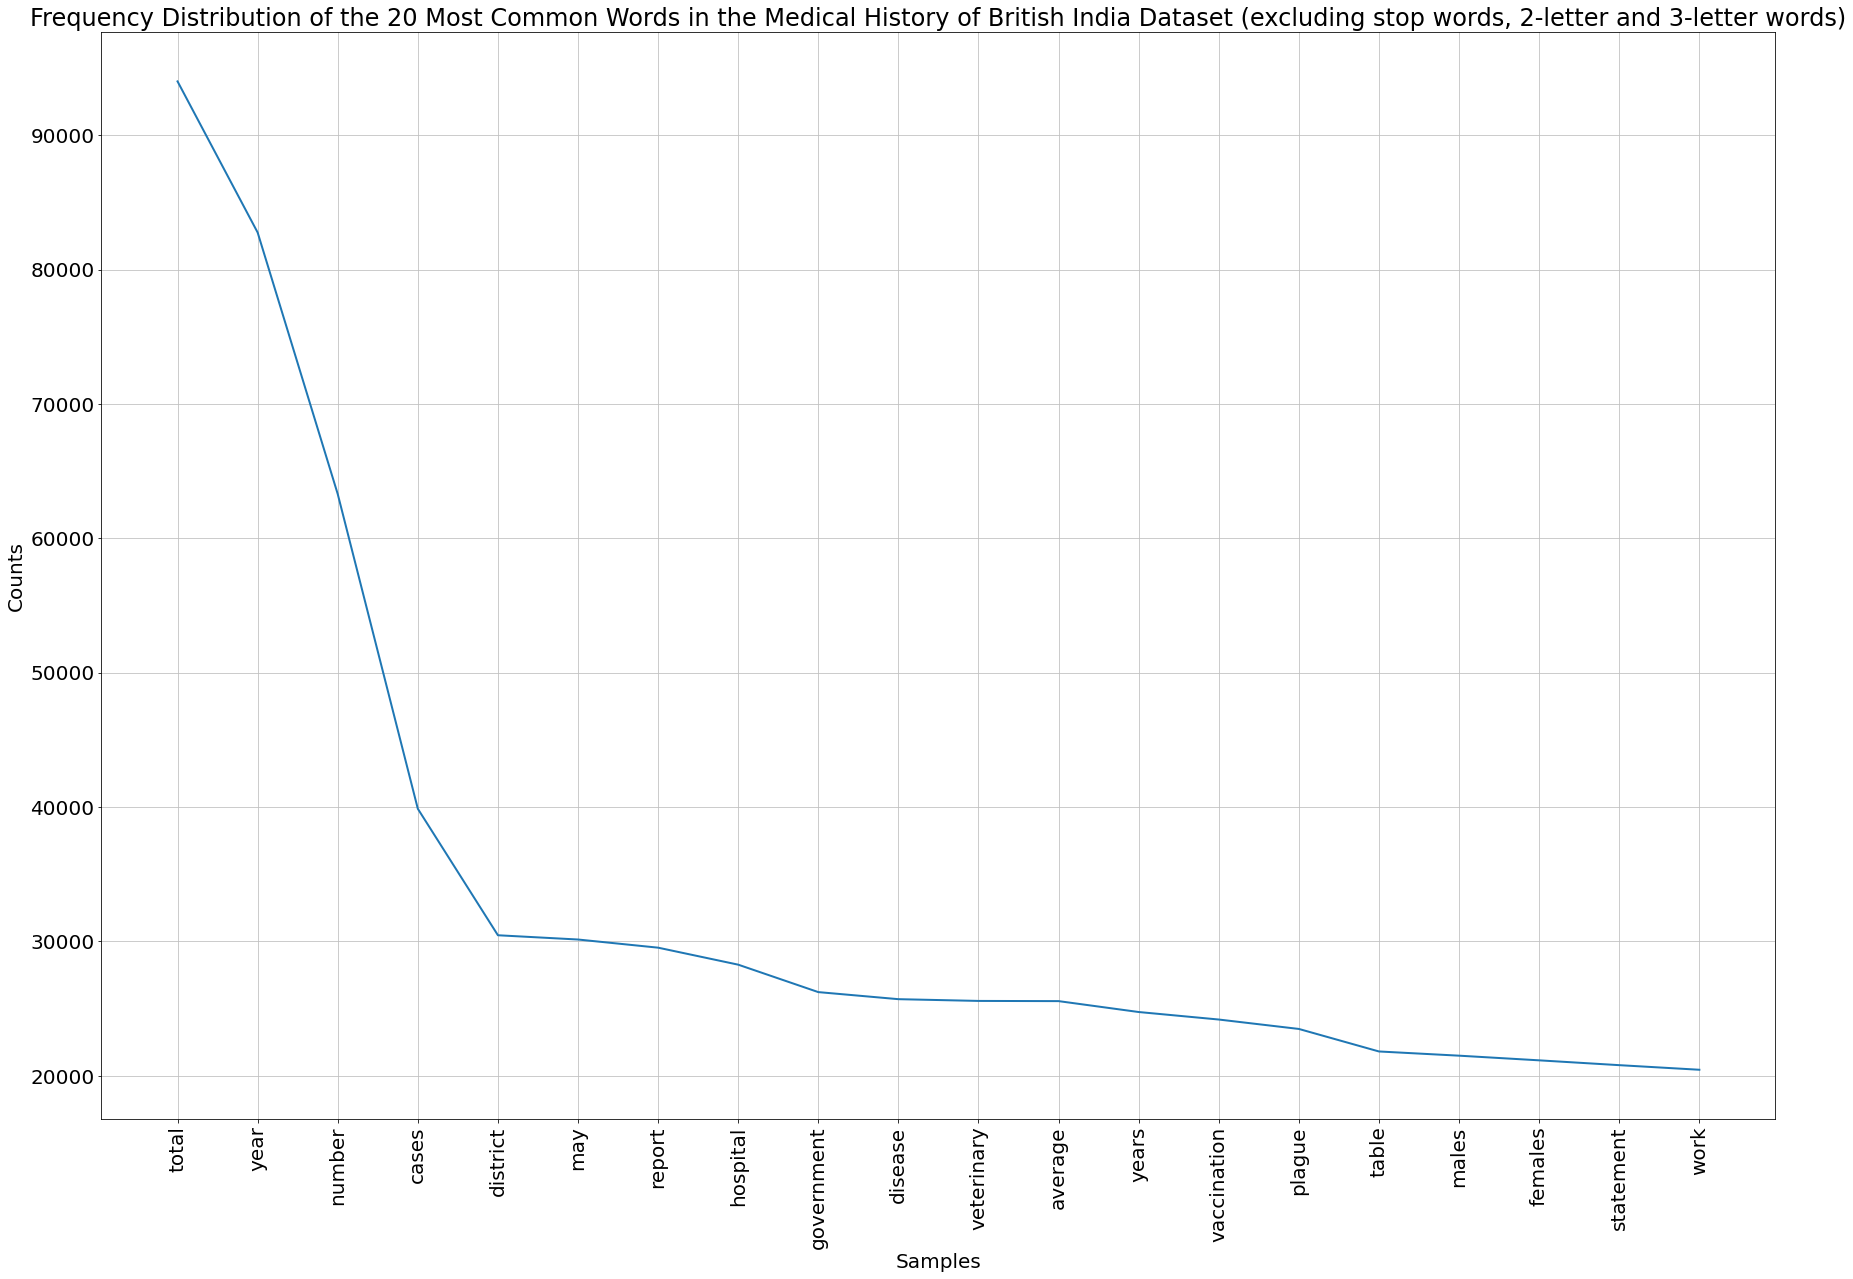

In [24]:
# Visualize the frequency distribution for a select number of tokens
plt.figure(figsize = (30, 20))                # customize the width and height of the plot
plt.rc('font', size=20)                       # customize the font size of the title, axes names, and axes labels
fdist_ft.plot(20, title='Frequency Distribution of the 20 Most Common Words in the Medical History of British India Dataset (excluding stop words, 2-letter and 3-letter words)')

The medical focus is clear from the top 20 words in the MHBI papers, which includes `cases`, `hospital`, `disease`, `veterinary`, `vaccination`, and `plauge`.  Also, the frequency distribution suggests the people writing the papers made an effort to summarize what was going on, since the top three tokens, by far, are `total`, `year`, and `number` (perhaps summarizing `cases` by `district`?).

Let's create a frequency distribution for lemmatized words and stemmed words to see if differences arise in the distributions:

Total tokens in filtered list: 8511109


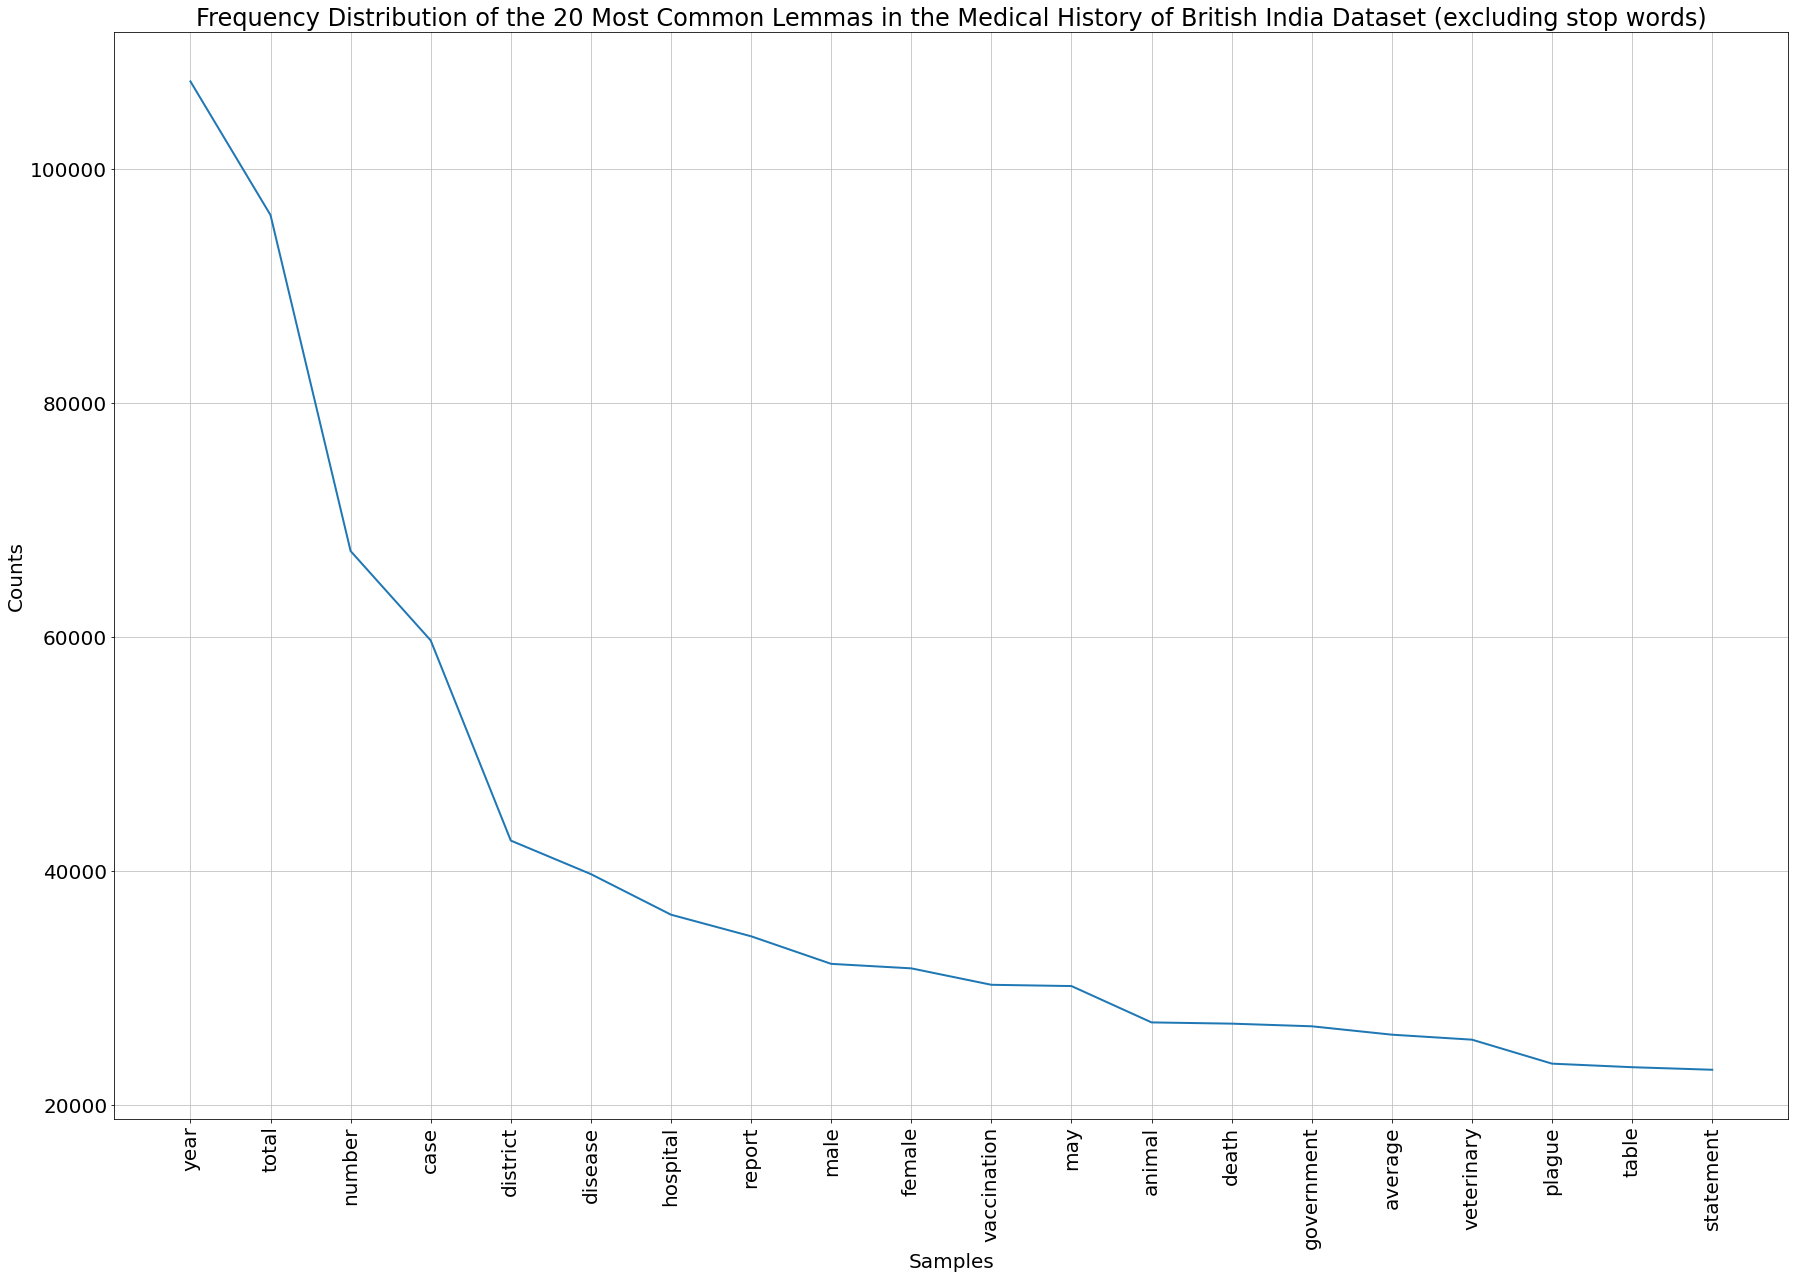

In [27]:
# Filter one-letter words, two-letter words, and  stop words out of the list of lemmatized tokens
min_three_letters = [l for l in lemmatized if len(l) > 2]
to_exclude = list(set(stopwords.words('english'))) + ["per", "two", "one", "also"]
filtered_lemmas = [l for l in min_three_letters if not l in to_exclude]
# Calculate the frequency distribution for the filtered list of tokens
fdist_fl = FreqDist(filtered_lemmas)
print("Total tokens in filtered list:", fdist_fl.N())
# Visualize the frequency distribution for a select number of tokens
plt.figure(figsize = (30, 20))                # customize the width and height of the plot
plt.rc('font', size=20)                       # customize the font size of the title, axes names, and axes labels
fdist_fl.plot(20, title='Frequency Distribution of the 20 Most Common Lemmas in the Medical History of British India Dataset (excluding stop words)')

`death` appears now, making the chart feel rather despairing!  To further this sentiment, `disease` has a higher recorded frequency than the last chart: 40,000 times instead of about 25,000 times.  I wonder how successful `vaccination` was in preventing the spread of `disease`...?

Total tokens in filtered list: 8720609


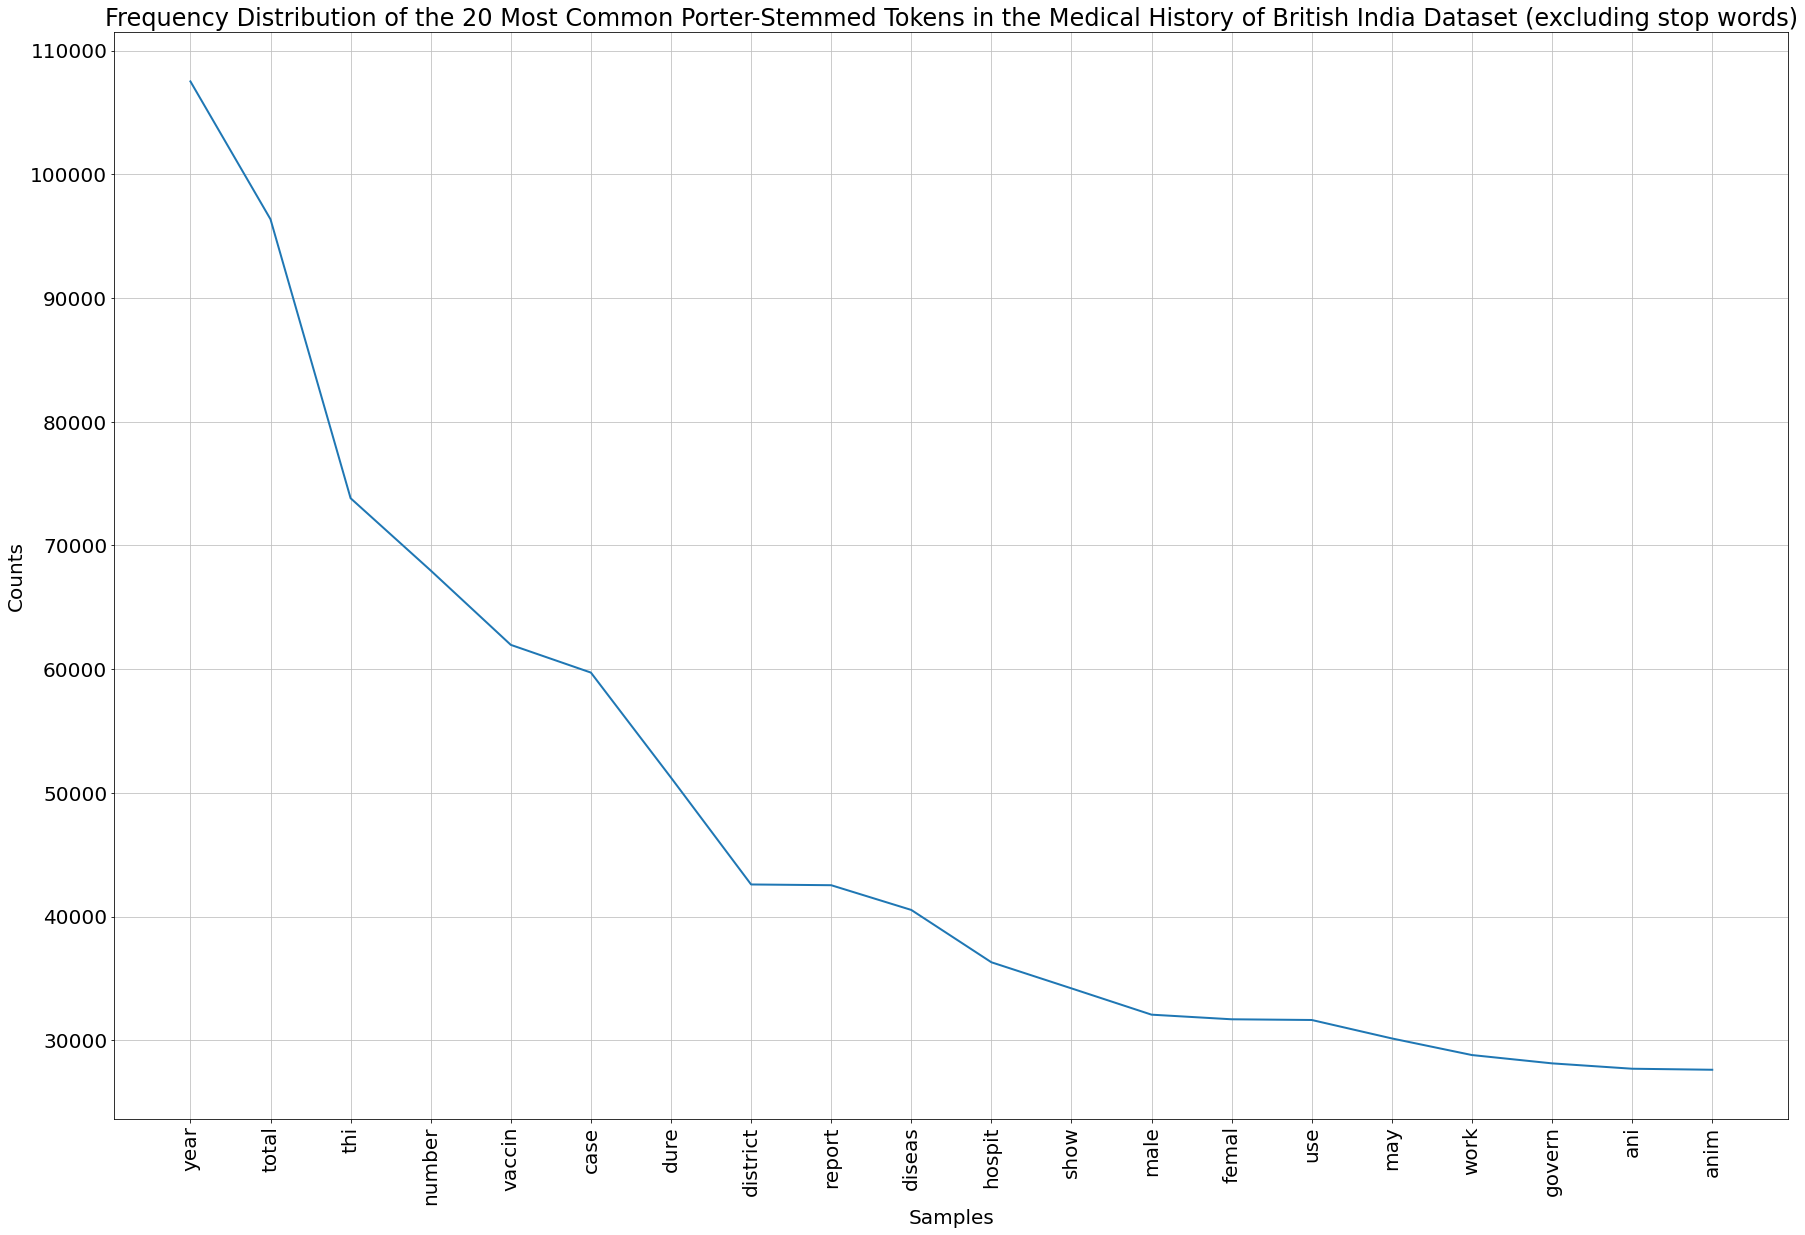

In [28]:
# Filter one-letter words, two-letter words, and  stop words out of the list of porter-stemmed tokens
min_three_letters = [s for s in porter_stemmed if len(s) > 2]
to_exclude = list(set(stopwords.words('english'))) + ["per", "two", "one", "also"]
filtered_pstems = [s for s in min_three_letters if not s in to_exclude]
# Calculate the frequency distribution for the filtered list of tokens
fdist_ps = FreqDist(filtered_pstems)
print("Total tokens in filtered list:", fdist_ps.N())
# Visualize the frequency distribution for a select number of tokens
plt.figure(figsize = (30, 20))                # customize the width and height of the plot
plt.rc('font', size=20)                       # customize the font size of the title, axes names, and axes labels
fdist_ps.plot(20, title='Frequency Distribution of the 20 Most Common Porter-Stemmed Tokens in the Medical History of British India Dataset (excluding stop words)')

The slope of the frequency distribution line isn't quite so steep when we look at word stems (using the Porter Stemmer, in this case).  The stem `vaccin` occurs with much higher frequency (about 60,000 times) than in the previous two charts (which record its frequency of occurrences at about 25,000 and 30,000 times).  What other differences can you spot?

#### 2.2 Uniqueness and Variety

Another way to summarize the MHBI dataset is to look at the uniqueness and variety of word usage.  We can obtain the **vocabulary** of the text by creating a set of unique words (alphabetic tokens) that occur in the dataset, as well as creating a set of unique *lemmatized* words that occur in the dataset.

In [30]:
# Remove duplicate words from the text (obtain the vocabulary of the text)
t_vocab = set(alpha_tokens)
t_vocab_lower = set(alpha_tokens_lower)
lemma_vocab = set(lemmatized)
print("Unique tokens:", len(t_vocab))
print("Unique lowercase tokens:", len(t_vocab_lower))
print("Unique lemmatized (lowercase) tokens:", len(lemma_vocab))

Unique tokens: 186247
Unique lowercase tokens: 151872
Unique lemmatized (lowercase) tokens: 144837


We can create a data visualization that illustrates when specific words are used within the MHBI dataset.  This is called a **Lexical Dispersion Plot**.  We'll pick some medical-related stems (the list of `targets`) to see when they appear (based on the Porter Stemmer):

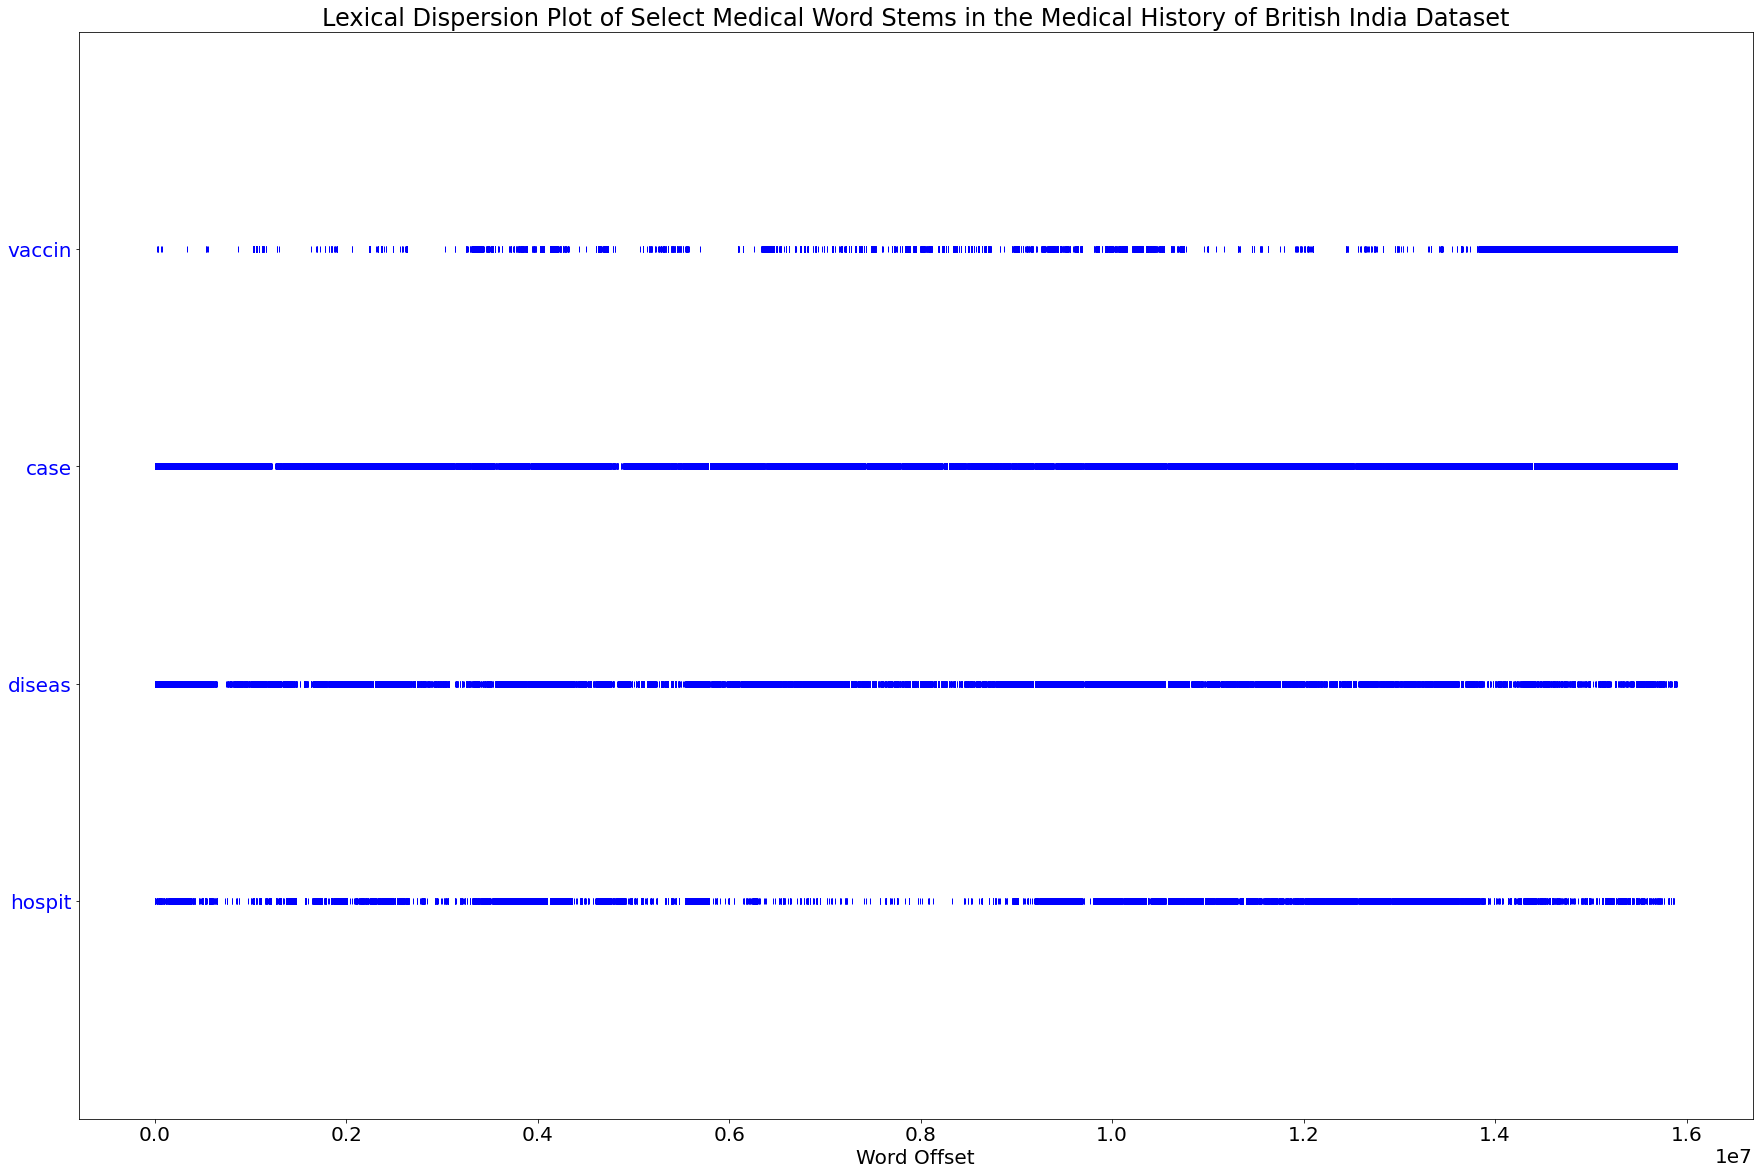

In [32]:
corpus_pstems = Text(porter_stemmed)
targets = ['vaccin', 'case', 'diseas', 'hospit']
plt.figure(figsize=(30,20))
plt.rc('font', size=20)
displt(corpus_pstems, targets, ignore_case=True, title='Lexical Dispersion Plot of Select Medical Word Stems in the Medical History of British India Dataset')

Interesting - the stem `vaccin` starts being used with increasing frequency...over time?  Let's check how the publications are ordered to see if it's chronologically:

### 3. Exploratory Analysis (this section will be included for 2-3 datasets)
[Code cells in this section will have one function each, preceded with comments in a markdown cell posing an exploratory research question]

#### 3.1 Which publications are about cholera?  Leprosy?  Malaria?  Plague?  "Laboratory Medicine?"

In [ ]:
# code goes here - disinfecting trains for cholera to help stop spread during religious festivals

In [ ]:
# visualizations go here

#### 3.2 How does the language around the people of India change over time?

*Especially after the 1857 rebellion when British East India Company rule in India was taken over by the British Crown*

In [ ]:
# code goes here - terms to search for: native(s), indigenous; patronizing sentiment...
# other colonial indicators?

In [ ]:
# visualizations go here

#### 3.3 How does the language around mental hospitals change over time?

In [ ]:
#  term to search: lunatic asylums

#### 3.4 How are women portrayed?

Consider lock(ed) hospitals and escapes from them, prostitutes permitted in army barracks

#### 3.5 What is the rhetoric around vaccinations and, more generally, public health?

In [ ]:
# Public health, field teams, indigenous population, teaching hospitals, vaccination programmes, 
# military personnel, anti-vaccine